# Livrable 2 - Traitement d'images

Groupe 2 :
- Brenda DJIGUEMDE
- Bruno DIAS
- Dany KHADHAR
- Romaric DEMBELE

## Contexte

L'objectif est de manipuler un ensemble d'images pour les optimiser pour le traitement par des algorithmes d'apprentissage automatique. Le processus à mettre en œuvre est une opération de débruitage. Ce notebook Jupyter détaille ces étapes de prétraitement et évalue leur efficacité. Ces algorithmes utilisent des auto-encodeurs à convolution pour améliorer la qualité de l'image.
Cahier de charges de ce livrable :

- Le code de chargement du fichier.
- Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.
- Une étude de cas.

## 1. Préparation de l'environnement 

### 1.1 Imports de librairies

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import numpy as np

2024-04-19 12:40:04.274108: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 12:40:04.659296: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1.2 Variables globales

On définit des paramètres pour l'entraînement de notre modèle de machine learning. `BATCH_SIZE` est la taille du lot d'échantillons qui sera passé à travers le réseau à chaque itération d'entraînement. `DATASET_PATH` est le chemin vers le répertoire contenant l'ensemble de données. `EPOCHS` est le nombre total de passages à travers l'ensemble de données d'entraînement. `STEPS_PER_EPOCH` et `VALIDATION_STEPS` sont respectivement le nombre de lots d'échantillons d'entraînement et de validation que le modèle verra à chaque époque, calculés en divisant le nombre total d'échantillons par la taille du lot.

In [2]:
BATCH_SIZE = 16  # Taille du batch
DATASET_PATH = './dataset_livrable_2' 

# Configuration de paramètres pour l'entraînement
EPOCHS = 200 # Nombre d'époques pour l'entraînement
STEPS_PER_EPOCH  = 120 // BATCH_SIZE  # Nombre de batches d'entraînement par époque
VALIDATION_STEPS = 32 // BATCH_SIZE  # Nombre de batches de validation par époque

## 2. Les données

### 2.1 Chargement des données

Dans ce code, nous commençons par créer un `DataFrame` qui contient les chemins vers toutes les images dans le répertoire spécifié. Ensuite, nous configurons un `ImageDataGenerator`pour normaliser les images et appliquer des modifications aléatoires comme la rotation, le zoom, et le décalage horizontal et vertical. Nous divisons également les données en un ensemble d'entraînement et un ensemble de validation avec une répartition de 80/20. Ensuite, nous utilisons `flow_from_dataframe` pour créer des générateurs de données d'entraînement et de validation qui chargent les images, les transforment en fonction des paramètres de l'`ImageDataGenerator`, et les regroupent en lots. Enfin, nous affichons la forme du premier lot de données d'entraînement pour vérifier que tout fonctionne comme prévu.

`ImageDataGenerator` est une classe de Keras qui est utilisée pour générer des lots d'images avec des transformations en temps réel. Cela signifie qu'elle peut générer des images modifiées à la volée pendant l'entraînement, ce qui permet de charger des images "à l'infini". On l'utilise dans notre cas car nous avons que 150 images. Cela permet d'ajouter de la variété en générant des images modifiées.

In [3]:
# Création d'un DataFrame contenant les chemins des images
image_paths = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_df = pd.DataFrame({'filename': image_paths})

# Configuration de l'ImageDataGenerator pour la normalisation en modifiant de façon aléatoire la rotation, le zoom, le décalage horizontal et vertical
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    width_shift_range=1,
    height_shift_range=1,
    zoom_range=2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Définit la répartition d'entraînement et de validation

)
# Création du générateur de données d'entraînement et de validation 
train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,  # Pas de labels car l'image est sa propre cible
    batch_size=BATCH_SIZE,
    subset='training',  # Défini pour utiliser la répartition de validation
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,  # Pas de labels
    batch_size=BATCH_SIZE,
    subset='validation',  # Défini pour utiliser la répartition de validation
    shuffle=True
)

# Affichage des informations sur le générateur
for data_batch in train_generator:
    print('Batch shape:', data_batch.shape)
    break  # Affiche seulement le premier lot


Found 119 validated image filenames.
Found 29 validated image filenames.
Batch shape: (16, 224, 224, 3)


### 2.2 Affichage des images

On affiche ensuite 9 images. 

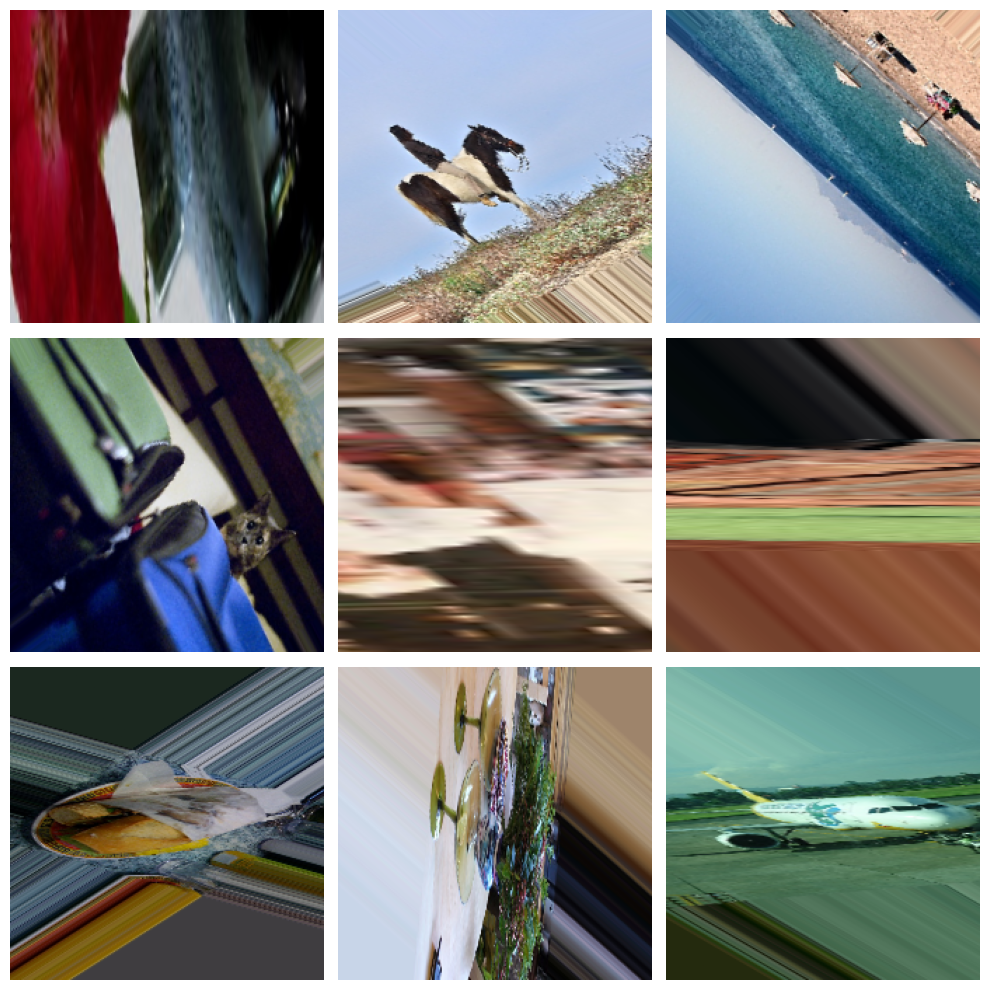

In [4]:
import matplotlib.pyplot as plt

def show_images(train_generator):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Crée un grid de 3x3 pour les images
    axes = axes.flatten()
    batch = next(iter(train_generator))  # Récupère un lot d'images du générateur
    for i, ax in enumerate(axes):
        if i < len(batch):  # Vérifie si l'index est inférieur au nombre d'images dans le lot
            ax.imshow(batch[i])  # Affiche l'image dans le subplot
            ax.axis('off')  # Désactive les axes
    plt.tight_layout()  # Ajuste la disposition
    plt.show()

# Appelle la fonction pour montrer les images
show_images(train_generator)


### 2.3 Création d'un jeu de données bruité

Dans ce code, nous avons défini deux fonctions principales pour ajouter du bruit à nos images. Nous avons choisi d'ajouter trois types de bruit : gaussien, sel et poivre, et poisson, de manière aléatoire. Le bruit gaussien est ajouté en générant des valeurs aléatoires à partir d'une distribution normale. Le bruit de sel et de poivre ajoute du "sel" (pixels blancs) et du "poivre" (pixels noirs) à l'image. Le bruit de Poisson est généré à partir d'une distribution de Poisson. L'ajout de ces types de bruit à nos images nous permet de rendre notre modèle plus robuste. En effet, dans le monde réel, les images que notre modèle pourrait avoir à traiter seront probablement affectées par divers types de bruit. En entraînant notre modèle sur des images bruitées, nous espérons qu'il sera capable de bien fonctionner même lorsque les images d'entrée ne sont pas parfaites.

In [5]:
import numpy as np

def add_noise(img, noise_level=0.1):
    # Choisis un type de bruit aléatoirement
    noise_types = ['gaussian', 'salt_pepper', 'poisson']
    noise_type = np.random.choice(noise_types)

    if noise_type == 'gaussian':
        noise = np.random.normal(loc=0.0, scale=noise_level, size=img.shape)
        img_noisy = img + noise
    elif noise_type == 'salt_pepper':
        row, col, ch = img.shape
        s_vs_p = 0.5
        amount = noise_level
        out = np.copy(img)
        # Salt mode
        num_salt = np.ceil(amount * img.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in img.shape]
        out[coords[0], coords[1], :] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * img.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in img.shape]
        out[coords[0], coords[1], :] = 0
        img_noisy = out
    elif noise_type == 'poisson':
        vals = len(np.unique(img))
        vals = 2 ** np.ceil(np.log2(vals))
        img_noisy = np.random.poisson(img * vals) / float(vals)
    else:
        raise ValueError("Unsupported noise type!")

    img_noisy = np.clip(img_noisy, 0, 1)  # Garantie que les valeurs restent dans [0, 1]
    return img_noisy

def noisy_generator(generator, noise_level=0.1):
    '''Generates pairs of noisy and original images.'''
    for batch in generator:
        original_batch = batch.copy()  # Copie les images originales avant d'ajouter les bruits 
        noisy_batch = np.array([add_noise(image, noise_level) for image in original_batch])
        yield noisy_batch, original_batch  # Retourne les images originales et les images bruitées 



On ajoute ensuite du bruit à nos différents jeux de données avec un niveau de bruitage (noise level) à 0.1. Plusieurs niveaux ont été testés mais n'ont pas eu d'impact sur la performance du modèle jusqu'à un niveau de 0.5 où il se dégrade.

In [6]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: noisy_generator(train_generator, noise_level=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # images bruitées
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)   # images Originales 
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: noisy_generator(validation_generator, noise_level=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # images bruitées 
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)   # images Originales 
    )
)

# Exemple d'usage
for x, y in train_dataset.take(1):
    print('Batch shape:', x.numpy().shape)

2024-04-19 12:40:27.421439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 12:40:27.479763: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 12:40:27.479803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 12:40:27.481966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 12:40:27.481992: I external/local_xla/xla/stream_executor

Batch shape: (16, 224, 224, 3)


2024-04-19 12:40:28.174447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Affichons quelques images originales avec leurs versions bruitées afin de vérifier que le bruitage a bien été effectué.

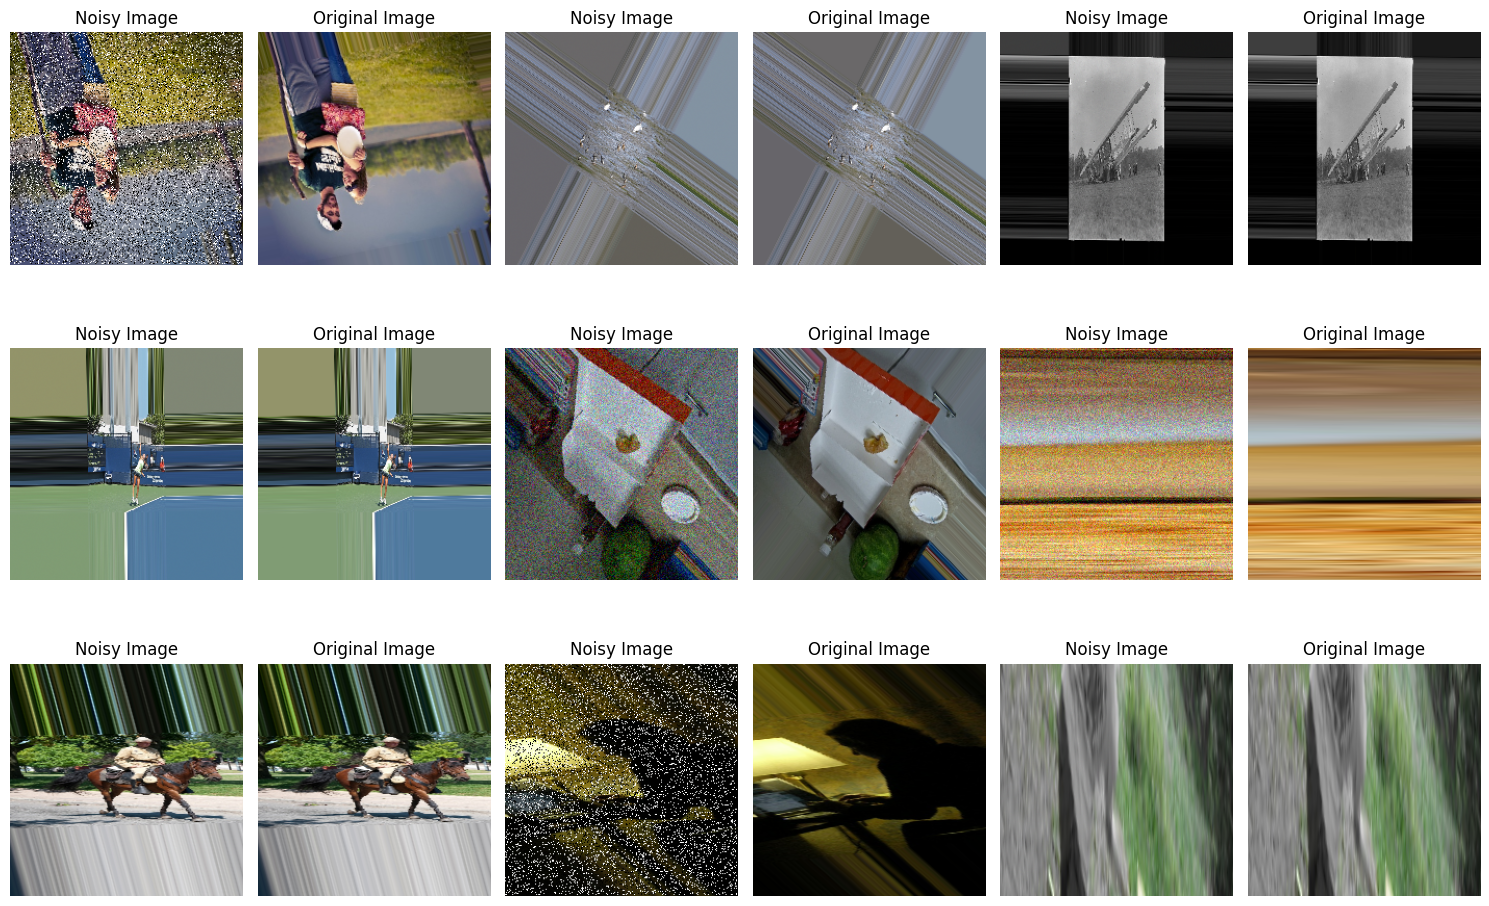

In [7]:
import matplotlib.pyplot as plt

def show_data_set_images(train_dataset):
    # Génère un batch à partir du dataset
    try:
        noisy_batch, original_batch = next(iter(train_dataset))
    except StopIteration:
        print("No more data available in the dataset.")
        return

    # Determine how many image pairs we can show
    num_images = len(noisy_batch)  # Get the number of images in the batch
    num_pairs_to_show = min(num_images, 9)  # Can show up to 9 pairs (since there are 18 subplots)

    # Set up the figure with a grid of 3 rows and 6 columns
    fig, axes = plt.subplots(3, 6, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_pairs_to_show):
        # Display the noisy image on the left
        ax_noisy = axes[2 * i]
        ax_noisy.imshow(noisy_batch[i])
        ax_noisy.axis('off')
        ax_noisy.set_title('Noisy Image')

        # Display the original image on the right
        ax_original = axes[2 * i + 1]
        ax_original.imshow(original_batch[i])
        ax_original.axis('off')
        ax_original.set_title('Original Image')

    # Hide any remaining unused axes
    for j in range(2 * num_pairs_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Affichage des images bruitées
show_data_set_images(train_dataset)


## Modèle auto-encodeur

### 3.1 Création du modèle auto-encodeur

Dans ce code, nous avons construit un auto-encodeur, un type de réseau de neurones utilisé pour l'apprentissage non supervisé, avec l'objectif spécifique de débruiter nos images. L'encodeur compresse l'image bruitée en une représentation de dimension inférieure, tandis que le décodeur tente de reconstruire l'image originale à partir de cette représentation, effectuant ainsi le débruitage. Les fonctions d'activation ReLU introduisent des non-linéarités, permettant au modèle d'apprendre des représentations plus complexes. Les couches MaxPooling dans l'encodeur réduisent la dimensionnalité, tandis que les couches UpSampling dans le décodeur augmentent la dimensionnalité, aidant à restaurer l'image originale. L'optimiseur Adam ajuste les poids du réseau pour minimiser l'erreur quadratique moyenne (MSE), qui mesure la différence entre l'image débruitée et l'image originale. Les paramètres du modèle, tels que le nombre de filtres dans les couches Conv2D et la taille du noyau, ont été ajustés à la fin par le tuning pour optimiser la capacité de débruitage du modèle.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_autoencoder(input_shape=(224, 224, 3)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(96, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(96, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(160, (3, 3), activation='relu', padding='same')(x)  # Ensure padding is 'same'
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Create the autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005355035267411966),
        loss='mse',
        metrics=['accuracy']
    )
    return autoencoder

# Build and summarize the autoencoder model
autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 96)   │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 96)   │       230,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 96)     │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 160)  │       138,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 160)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 3)    │         4,323 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,963 (2.61 MB)

 Trainable params: 684,963 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Entrainement du modèle

Entraînons notre auto-encodeur sur l'ensemble de données d'entraînement. Nous spécifions un certain nombre d'époques, qui représentent le nombre de fois où l'ensemble du jeu de données est passé à travers le réseau. Nous définissons également le nombre de pas par époque, qui est le nombre de lots d'échantillons à tirer de l'ensemble de données d'entraînement à chaque époque. De plus, nous fournissons un ensemble de données de validation et le nombre de pas de validation. Ces derniers sont utilisés pour évaluer les performances du modèle sur des données non vues à chaque fin d'époque, ce qui nous permet de surveiller si le modèle surajuste les données d'entraînement. L'objet history retourné par la méthode fit contient les valeurs de perte et de métrique à chaque époque, à la fois pour l'entraînement et la validation, ce qui nous permet d'analyser la progression de l'entraînement.

In [10]:
# Entraînement de l'autoencodeur
history = autoencoder.fit(
    x=train_dataset,  # Données d'entraînement
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,  # Données de validation
    validation_steps=VALIDATION_STEPS
)

Epoch 1/200


I0000 00:00:1713520078.647541   11661 service.cc:145] XLA service 0x7fef2000efe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713520078.647592   11661 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-04-19 09:47:58.717874: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-19 09:47:58.895730: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-04-19 09:48:13.926651: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,96,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,96,112,112]{3,2,1,0}, f32[96,96,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_o

1/7 ━━━━━━━━━━━━━━━━━━━━ 3:18 33s/step - accuracy: 0.2626 - loss: 0.0857

I0000 00:00:1713520109.067922   11661 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.2619 - loss: 0.0874

2024-04-19 09:48:40.729169: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.97GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


3/7 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.2753 - loss: 0.0855  

I0000 00:00:1713520124.292389   11659 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 36 bytes spill stores, 36 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.3288 - loss: 0.0806 - val_accuracy: 0.4322 - val_loss: 0.0591
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.5254 - loss: 0.0615 - val_accuracy: 0.4699 - val_loss: 0.0735
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.4551 - loss: 0.0614 - val_accuracy: 0.5894 - val_loss: 0.0415
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.5233 - loss: 0.0472 - val_accuracy: 0.5529 - val_loss: 0.0424
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.4956 - loss: 0.0348 - val_accuracy: 0.4876 - val_loss: 0.0377
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.4644 - loss: 0.0344 - val_accuracy: 0.5651 - val_loss: 0.0251
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.6149 - loss: 0.0256 - val_accuracy: 0.6181 - val_loss: 0.0200
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.6182 - loss: 0.0217 - val_accuracy: 0.5465 - val_loss: 0.015

### 3.3 Les métriques

On trace les courbes afin de voir l'évolution de l'`accuracy` et de la `fonction` loss suivant les époques.

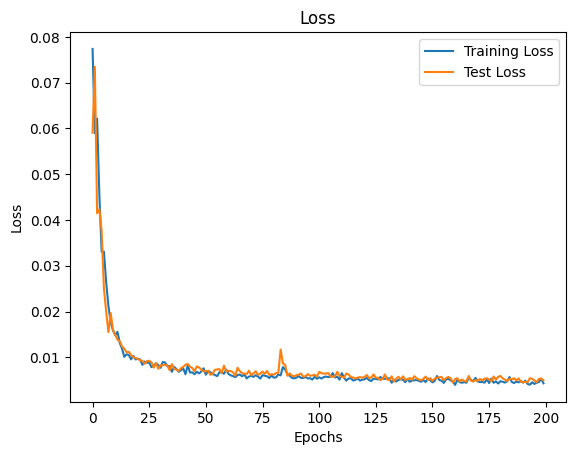

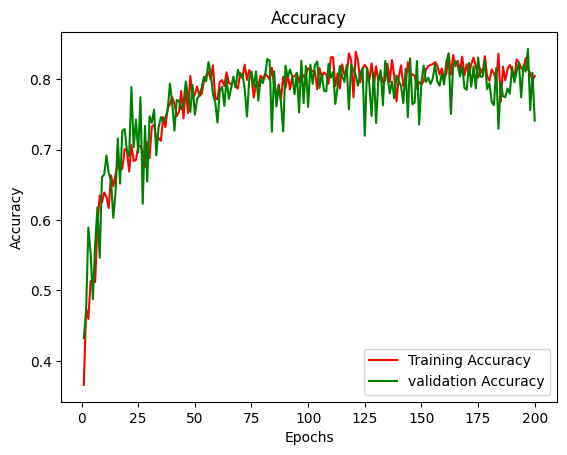

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Plotting the training accuracy
loss = history.history['loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



Interpretatons

### 3.4 Les prédictions

On affiche les images débruitées grâce à notre auto-encodeur. Ces images proviennent du premier batch de notre jeu de données de validation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


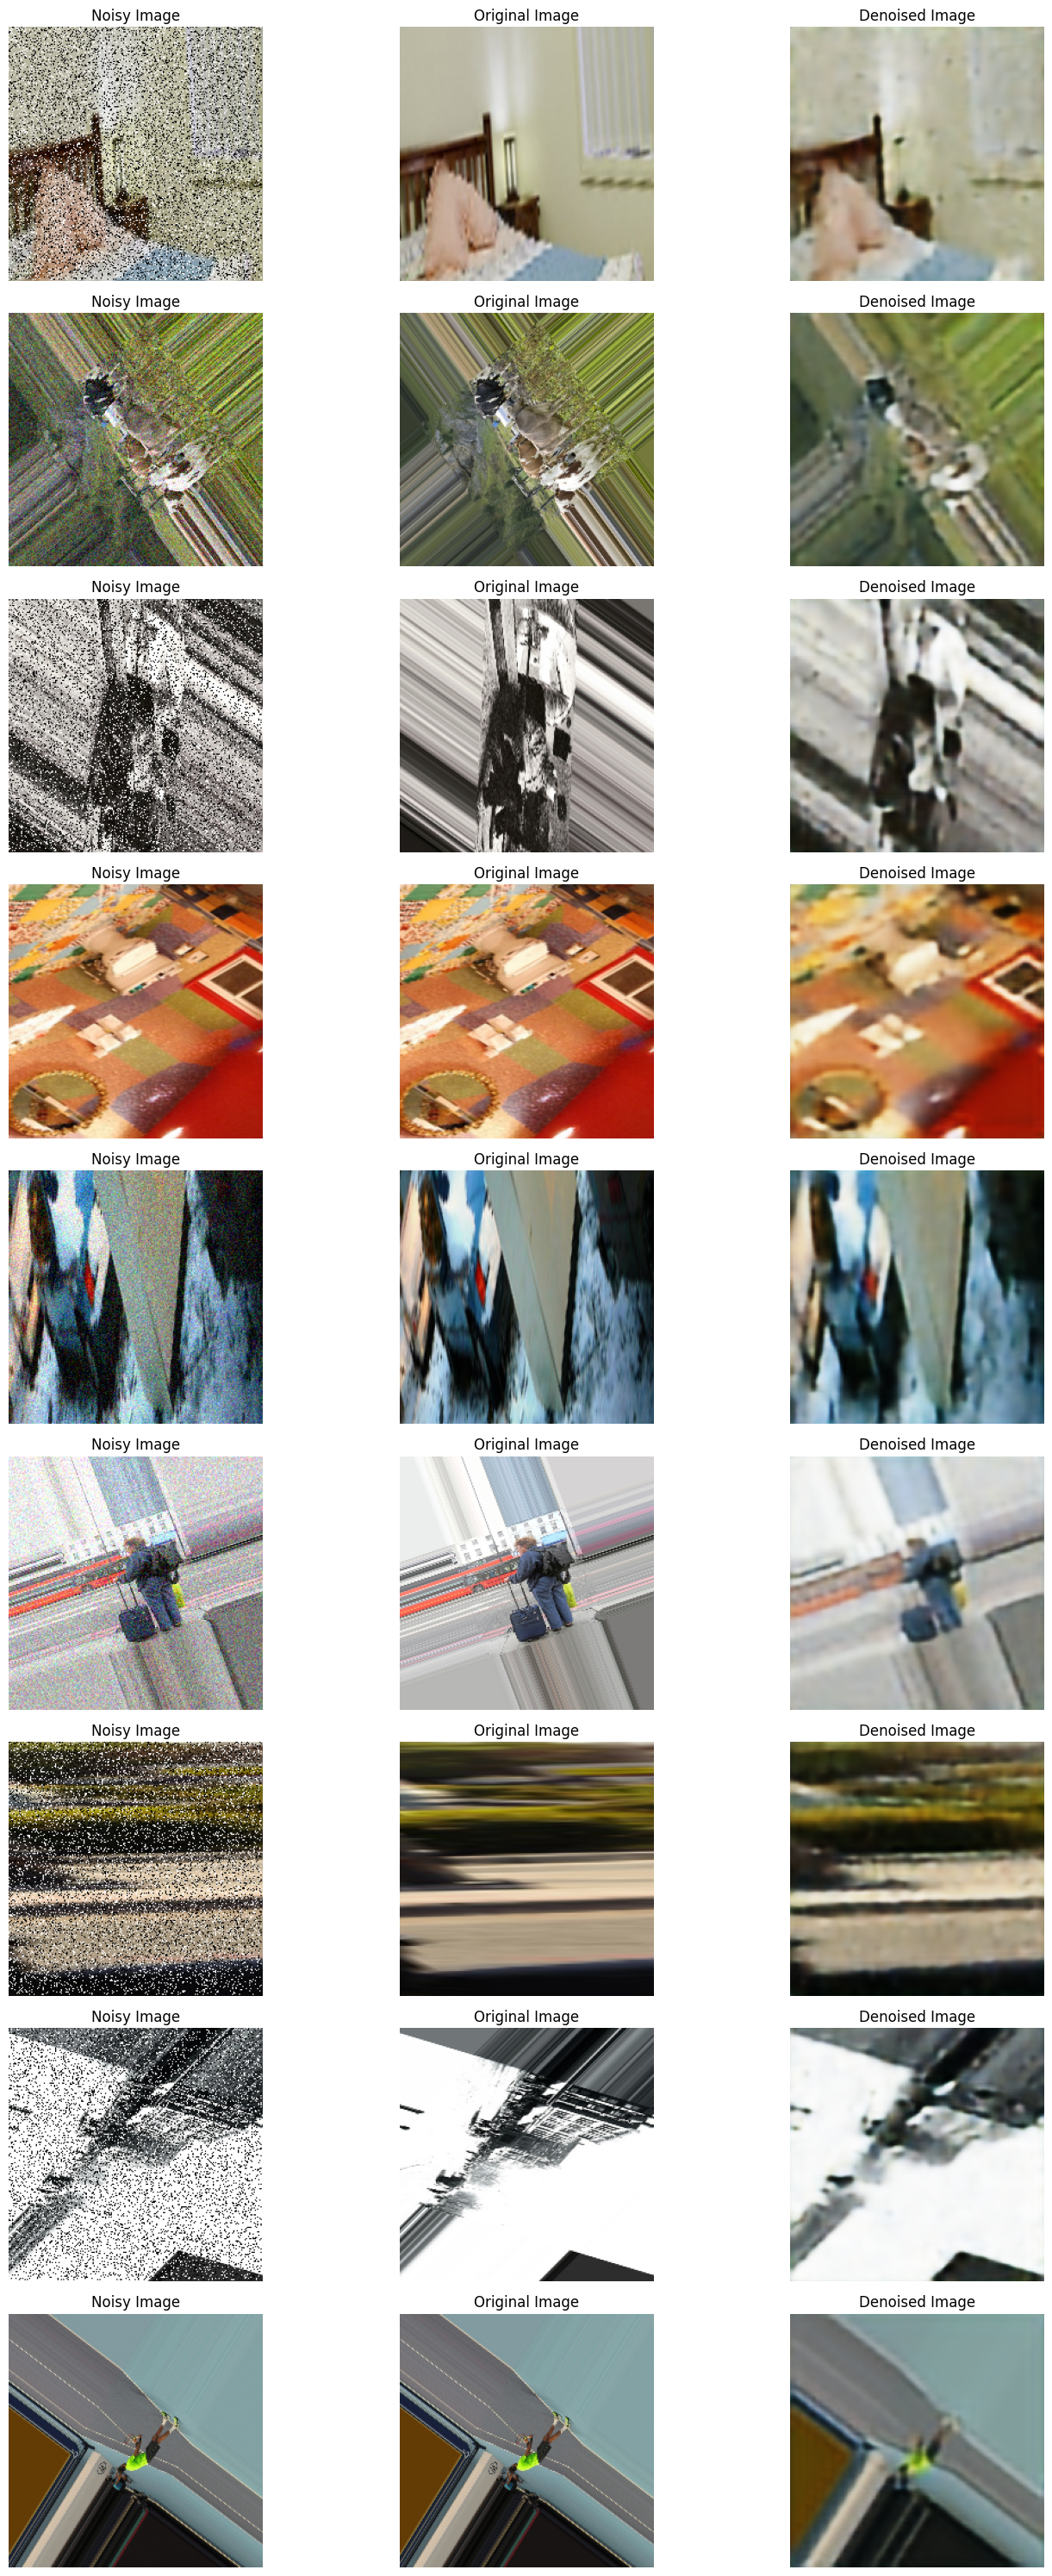

In [12]:

def show_predictions(autoencoder, dataset):
    # Generate a batch of images from the dataset
    try:
        noisy_batch, original_batch = next(iter(dataset))
    except StopIteration:
        print("No more data available in the dataset.")
        return

    # Generate denoised images using the trained autoencoder
    denoised_batch = autoencoder.predict(noisy_batch)

    # Determine how many image pairs we can show
    num_images = len(noisy_batch)  # Get the number of images in the batch
    num_pairs_to_show = min(num_images, 9)  # Can show up to 9 pairs (since there are 27 subplots)

    # Set up the figure with a grid of 9 rows and 3 columns
    fig, axes = plt.subplots(9, 3, figsize=(15, 30))
    axes = axes.flatten()

    for i in range(num_pairs_to_show):
        # Display the noisy image on the left
        ax_noisy = axes[3 * i]
        ax_noisy.imshow(noisy_batch[i])
        ax_noisy.axis('off')
        ax_noisy.set_title('Noisy Image')

        # Display the original image in the middle
        ax_original = axes[3 * i + 1]
        ax_original.imshow(original_batch[i])
        ax_original.axis('off')
        ax_original.set_title('Original Image')

        # Display the denoised image on the right
        ax_denoised = axes[3 * i + 2]
        ax_denoised.imshow(denoised_batch[i])
        ax_denoised.axis('off')
        ax_denoised.set_title('Denoised Image')

    # Hide any remaining unused axes
    for j in range(3 * num_pairs_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()



# Show the denoised images
show_predictions(autoencoder, validation_dataset)

On voit que les images sont débruitées mais restent cependant un peu floues.

### 3.5 Evaluation de la qualité des images débruitées.

Dans ce segment de code, nous définissons d'abord une fonction `predict_and_calculate_psnr` qui utilise notre modèle pour débruiter des images et calculer le rapport signal sur bruit en `pic (PSNR)` entre les images originales et les images débruitées. Ensuite, nous définissons une fonction `evaluate_model` pour évaluer notre auto-encodeur sur un ensemble de données. Cette fonction itère sur l'ensemble de données par lots, en s'arrêtant après un nombre spécifié de lots. Pour chaque lot, elle calcule le `PSNR` et l'ajoute à une liste. Elle enregistre également le temps nécessaire pour traiter chaque lot et le nombre total de lots traités. Après avoir traité tous les lots, elle concatène toutes les valeurs de `PSNR` et calcule la moyenne. Enfin, elle affiche le temps total d'évaluation et le `PSNR` moyen. Nous utilisons cette fonction pour évaluer notre auto-encodeur sur l'ensemble de données de validation, en supposant que nous avons défini un nombre approprié de pas de validation.

Le `PSNR` est une mesure couramment utilisée pour évaluer la qualité de la reconstruction d'images. Un PSNR plus élevé indique une meilleure qualité de reconstruction. 

In [13]:
import tensorflow as tf
import time

@tf.function
def predict_and_calculate_psnr(model, noisy_images, original_images):
    denoised_images = model(noisy_images, training=False)  # Ensure inference mode
    psnr_values = tf.image.psnr(original_images, denoised_images, max_val=1.0)
    return psnr_values

def evaluate_model(autoencoder, dataset, num_batches):
    psnr_values = []
    batch_count = 0
    start_time = time.time()

    # Itérer sur le dataset avec une limite sur le nombre de batches
    for noisy_batch, original_batch in dataset:
        if batch_count >= num_batches:
            break  # Arrêtez la boucle après le nombre spécifié de batches

        batch_start_time = time.time()

        # Effectuer la prédiction et calculer le PSNR
        psnr = predict_and_calculate_psnr(autoencoder, noisy_batch, original_batch)

        # Ajouter les valeurs de PSNR à la liste, en gardant les opérations dans TensorFlow
        psnr_values.append(psnr)  # Ajouter le tensor TF à la liste

        batch_end_time = time.time()
        batch_count += 1

        # Logs pour chaque batch
        print(f"Batch {batch_count}: Calculated PSNR for {len(noisy_batch)} images.")
        print(f"Time for batch {batch_count}: {batch_end_time - batch_start_time:.2f} seconds")

    total_time = time.time() - start_time

    # Concaténer toutes les valeurs de PSNR et calculer la moyenne
    all_psnr = tf.concat(psnr_values, axis=0)
    average_psnr = tf.reduce_mean(all_psnr).numpy()  # Convertir en numpy après les calculs

    # Logs de processus final
    print(f"Evaluated {batch_count} batches in total.")
    print(f"Total evaluation time: {total_time:.2f} seconds")
    print(f"Average PSNR: {average_psnr:.2f} dB")

    return average_psnr

# Supposons que vous ayez défini VALIDATION_STEPS quelque part
psnr = evaluate_model(autoencoder, validation_dataset, VALIDATION_STEPS)
print(f'Average PSNR: {psnr:.2f} dB')


2024-04-19 09:54:14.245301: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Batch 1: Calculated PSNR for 13 images.
Time for batch 1: 4.68 seconds


2024-04-19 09:54:18.907877: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Batch 2: Calculated PSNR for 16 images.
Time for batch 2: 4.62 seconds
Evaluated 2 batches in total.
Total evaluation time: 9.77 seconds
Average PSNR: 23.61 dB
Average PSNR: 23.61 dB


Notre `PSNR moyen est de 23.61 dB`, ce qui est relativement faible. Cela veut dire que notre auto-encodeur n'est pas capable de débruiter efficacement les images. Une raison possible de ce faible score pourrait être le nombre insuffisant d'images dans notre ensemble de données. En effet, un ensemble de données plus grand aurait permis à notre modèle d'apprendre une plus grande variété de caractéristiques de bruit, ce qui aurait pu améliorer sa capacité à débruiter les images. Par conséquent, pour améliorer les performances de notre auto-encodeur, nous pourrions envisager d'augmenter la taille de notre ensemble de données.

## 4. Le tuning 

Nous définissons une classe `AutoencoderHyperModel` qui construit un auto-encodeur avec des hyperparamètres tels que le nombre de filtres et la taille du noyau pour chaque couche convolutive, et le taux d'apprentissage pour l'optimiseur Adam. Nous utilisons ensuite le tuner Hyperband de Keras Tuner pour optimiser ces hyperparamètres, en cherchant les meilleurs sur l'ensemble de données d'entraînement et en validant sur l'ensemble de données de validation. Après la recherche, nous récupérons et imprimons les meilleurs hyperparamètres, puis nous construisons un nouveau modèle avec ces hyperparamètres et affichons son résumé.

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband

class AutoencoderHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
        
    def build(self, hp):
        input_img = Input(shape=self.input_shape)
        # Encoder
        x = Conv2D(
            filters=hp.Int('encoder_filter_1', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('encoder_kernel_size_1', values=[3, 5]),
            activation='relu',
            padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(
            filters=hp.Int('encoder_filter_2', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('encoder_kernel_size_2', values=[3, 5]),
            activation='relu',
            padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # Decoder
        x = Conv2D(
            filters=hp.Int('decoder_filter_1', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('decoder_kernel_size_1', values=[3, 5]),
            activation='relu',
            padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(
            filters=hp.Int('decoder_filter_2', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('decoder_kernel_size_2', values=[3, 5]),
            activation='relu',
            padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer=Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='mse', metrics=["accuracy"])

        return autoencoder

input_shape = (224, 224, 3)
hypermodel = AutoencoderHyperModel(input_shape)

tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    max_epochs=200,
    factor=3,
    directory='autoencoder_tuning',
    project_name='autoencoder_denoise',
    seed=42
)

# Perform the hyperparameter tuning
tuner.search(train_dataset, validation_data=validation_dataset, epochs=200, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
# Print all the best hyperparameters for all Conv2D layers
print("Best encoder hyperparameters:")
print(f"Encoder filter 1: {best_hps.get('encoder_filter_1')}")
print(f"Encoder kernel size 1: {best_hps.get('encoder_kernel_size_1')}")
print(f"Encoder filter 2: {best_hps.get('encoder_filter_2')}")
print(f"Encoder kernel size 2: {best_hps.get('encoder_kernel_size_2')}")
print("Best decoder hyperparameters:")
print(f"Decoder filter 1: {best_hps.get('decoder_filter_1')}")
print(f"Decoder kernel size 1: {best_hps.get('decoder_kernel_size_1')}")
print(f"Decoder filter 2: {best_hps.get('decoder_filter_2')}")
print(f"Decoder kernel size 2: {best_hps.get('decoder_kernel_size_2')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

# Build the model with the best hyperparameters and show its summary
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Trial 251 Complete [00h 05m 55s]
val_loss: 0.0029014642350375652

Best val_loss So Far: 0.002070127986371517
Total elapsed time: 03h 33m 59s

Search: Running Trial #252

Value             |Best Value So Far |Hyperparameter
160               |64                |encoder_filter_1
3                 |3                 |encoder_kernel_size_1
160               |160               |encoder_filter_2
3                 |3                 |encoder_kernel_size_2
96                |128               |decoder_filter_1
5                 |3                 |decoder_kernel_size_1
128               |160               |decoder_filter_2
3                 |3                 |decoder_kernel_size_2
0.00022534        |0.0017725         |learning_rate
200               |200               |tuner/epochs
0                 |67                |tuner/initial_epoch
0                 |4                 |tuner/bracket
0                 |4                 |tuner/round

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - 

I0000 00:00:1713533858.648299      62 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 36 bytes spill stores, 36 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - accuracy: 0.4366 - loss: 0.0714 - val_accuracy: 0.4006 - val_loss: 0.0506
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.4630 - loss: 0.0545 - val_accuracy: 0.6361 - val_loss: 0.0382
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.6157 - loss: 0.0460 - val_accuracy: 0.5034 - val_loss: 0.0383
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.4870 - loss: 0.0393 - val_accuracy: 0.6216 - val_loss: 0.0265
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.5767 - loss: 0.0339 - val_accuracy: 0.4939 - val_loss: 0.0302
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.6064 - loss: 0.0262 - val_accuracy: 0.6983 - val_loss: 0.0209
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.6693 - loss: 0.0177 - val_accuracy: 0.5505 - val_loss: 0.0208
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.6933 - loss: 0.0174 - val_accuracy: 0.6467 - val_loss: 0.0

Commentaires

## 5. Sauvegarde de l'autoencodeur

Sauvegardons notre modèle.

In [15]:
autoencoder.save('livrable_2_autoencoder.keras')  # Sauvegarde du modèle

## Conclusion 
 
 On a voulu créer un auto-encodeur pour débruiter les images. nous sommes partis d'une base de 150 images  que nous avons découpé en 80% et 20% de jeux de données. On a voulu augmenter notre base de données en dupliquant nos images avec des modifications. on a ajouté plusieurs types de bruits à nos images pour apporter de la variété. nous avons appliqué par la suite un auto-encodeur avec des couches convolutives. Ensuite on a utilisé du PNSR pour pouvoir vérifier la perfomance du debruitage par rapport aux images originale. et enfin nous avons mis en place un algo de tuning afin d'optimiser les performences de notre modèle